In [4]:
import torch
from einops.layers.torch import Rearrange
from einops import repeat, rearrange
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

## Resources 
- [Vision Transformers](https://arxiv.org/pdf/2010.11929.pdf)
- [Attention by lucidrains](https://github.com/lucidrains/vit-pytorch/blob/4b8f5bc90002a5506d765c811b554760d8dd6ee7/vit_pytorch/vit.py#L35)
- [Transformers by lucidrains](https://github.com/lucidrains/vit-pytorch/blob/4b8f5bc90002a5506d765c811b554760d8dd6ee7/vit_pytorch/vit.py#L67)
- [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)


Lets understand `Vision Transformer` in 6 simple steps 

## step-1
The following are the inputs required by the vision transformer. 
- input image size. 
- patch_size 

from this we can calculate the number of patches and patch_dimension in the following way

> If the image is of size (H, W) and our patch size (PxP). we reshape the image to $I^{N, P^2xC}$ where C is the number of channels and N= HxW/$P^2$

#### Showing fold and unfold in pytorch


<img src="../images/fold.png" alt="alt text" width="512" align="left"/>

In [5]:
class Patchify(nn.Module):
    def __init__(self, patch_size=56, stride_size=56):
        super().__init__()
        self.p = patch_size
        self.unfold = torch.nn.Unfold(kernel_size=patch_size, stride=stride_size)

    def forward(self, x):
        # x -> B c h w
        bs, c, h, w = x.shape
        
        x = self.unfold(x)
        # x -> B (c*p*p) L
        print(x.shape)
        # Reshaping into the shape we want
        a = x.view(bs, c, self.p, self.p, -1).permute(0, 4, 1, 2, 3)
        # a -> ( B no.of patches c p p )
        return a

In [6]:
patch = Patchify(patch_size=56, stride_size=56)
img_src = "/home/users/akshay.v/nano_models/images/guitar.jpg"
image = cv2.imread(img_src)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
image = image.astype('float32') / 255.0  # Normalize to [0, 1]
image = torch.Tensor(image)
image = image.permute(2,0,1) # C , H ,W
image = image.unsqueeze(0) #to add the batch dimension
p = patch(image)
print(p.shape)
p = p.squeeze() #to remove the batch dimension for plotting

torch.Size([1, 9408, 16])
torch.Size([1, 16, 3, 56, 56])


In [68]:
3*14*14

588

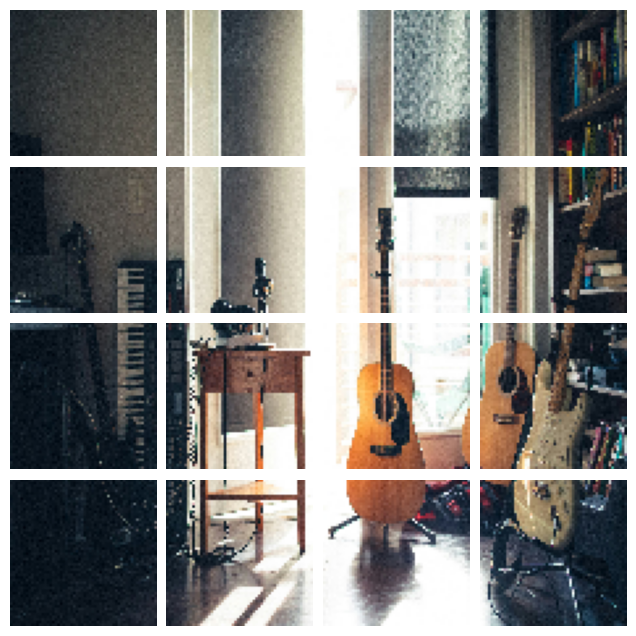

In [69]:
def plot_patches(tensor):
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

    for i, ax in enumerate(grid):
        patch = tensor[i].permute(1, 2, 0).detach()
        ax.imshow(patch)
        ax.axis('off')

    plt.show()

plot_patches(p)

In [70]:
image = torch.randn((224*224*3)).reshape((224, 224, 3))
image_shape = image.shape
patch_size = (14, 14)

image_height, image_width, channels = image_shape
patch_height, patch_width = patch_size

In [71]:
num_patches = (image_height // patch_height) * (image_width // patch_width)
patch_dim = channels * patch_height * patch_width

print(f"total_patches: {num_patches}")
print(f"patch_dim: {patch_dim}")

total_patches: 256
patch_dim: 588


In [72]:
224/14

16.0

we can achieve the same with using a conv layer of 14x14 to get 16x16 patches

In [10]:
patch = Patchify(patch_size=14, stride_size=14)
img_src = "/home/users/akshay.v/nano_models/images/guitar.jpg"
image = cv2.imread(img_src)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
image = image.astype('float32') / 255.0  # Normalize to [0, 1]
image = torch.Tensor(image)
image = image.permute(2,0,1) # C , H ,W
image = image.unsqueeze(0) #to add the batch dimension
print(image.shape)
p = patch(image)
print(p.shape)
p = p.squeeze() #to remove the batch dimension for plotting
print(p.reshape(1,p.shape[0],-1).shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 588, 256])
torch.Size([1, 256, 3, 14, 14])
torch.Size([1, 256, 588])


In [ ]:
torch.Size([1, 3, 65536])
torch.Size([1, 65536, 3, 1, 1])
torch.Size([1, 65536, 3])

In [1]:
588*256

150528

> Reshape the input image to [batch_size, total_patches, patch_dim]
THis is similar to passing a convlution of 14x14 with a stride of 14 and then getting 16x16 patches as demonstrated above

In [74]:
image.shape

torch.Size([1, 3, 224, 224])

In [77]:
mr = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width)
out = mr(image)
out.shape

torch.Size([1, 256, 588])

> As showin in this this repo https://github.com/Jack-Etheredge/early_convolutions_vit_pytorch , we can also pass it though a convolution and get features before directly passing it to the transformer 3x3 conv, stride 1, 5 conv layers per https://arxiv.org/pdf/2106.14881v2.pdf

$$
\text{Output\_Size} = \left( \frac{\text{Input\_Size} - \text{Filter\_Size} + 2 \times \text{Padding}}{\text{Stride}} \right) + 1
$$

In [78]:
channels=3
dim_head=64 
dropout=0 
emb_dropout=0
dim=128

n_filter_list = (channels, 48, 96, 192, 384)
conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(in_channels=n_filter_list[i],
                          out_channels=n_filter_list[i + 1],
                          kernel_size=3,  # hardcoding for now because that's what the paper used
                          stride=2,  # hardcoding for now because that's what the paper used
                          padding=1),  # hardcoding for now because that's what the paper used
            )
                for i in range(len(n_filter_list)-1)
            ])
# torch.Size([1, 48, 112, 112]) // (224-3+2)/2 + 1 = 112
# torch.Size([1, 96, 56, 56])
# torch.Size([1, 192, 28, 28])
# torch.Size([1, 384, 14, 14])

conv_layers.add_module("conv_1x1", torch.nn.Conv2d(in_channels=n_filter_list[-1], 
                                    out_channels=dim, 
                                    stride=1,  # hardcoding for now because that's what the paper used 
                                    kernel_size=1,  # hardcoding for now because that's what the paper used 
                                    padding=0))  # hardcoding for now because that's what the paper used

# torch.Size([1, 128, 14, 14])
conv_layers.add_module("flatten image", Rearrange('batch channels height width -> batch (height width) channels'))
# torch.Size([1, 196, 128])

In [79]:
conv_layers

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (1): Sequential(
    (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (2): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (3): Sequential(
    (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv_1x1): Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1))
  (flatten image): Rearrange('batch channels height width -> batch (height width) channels')
)

In [80]:
img_src = "/home/users/akshay.v/nano_models/images/guitar.jpg"
image = cv2.imread(img_src)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
image = image.astype('float32') / 255.0  # Normalize to [0, 1]
image = torch.Tensor(image)
image = image.permute(2,0,1) # C , H ,W
image = image.unsqueeze(0) #to add the batch dimension
image.shape

torch.Size([1, 3, 224, 224])

In [81]:
out_c = conv_layers(image)

In [82]:
out_c.shape

torch.Size([1, 196, 128])

## step-2
> The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection. We refer to the output of this projection as the `patch embeddings`.

In [83]:
embed_dim = 128
embed = torch.nn.Linear(588, 128)
with torch.no_grad():
    embed_out = embed(out)
print(embed_out.shape)

torch.Size([1, 256, 128])


## step-3
> Similar to BERT’s [class] token, we prepend a learnable embedding to the sequence of embedded patches ($z^0_{0}$ = xclass), whose state at the output of the Transformer encoder ($z^0_{L}$) serves as the image representation y (Eq. 4). 

In [84]:
cls_token = torch.nn.Parameter(torch.randn(1, 1, embed_dim))
cls_token.shape

torch.Size([1, 1, 128])

we have to repeat this `cls_token` batch_size times and concat with our `step-2` output
> we can use one of `torch.repeat` or `eniops repeat` 

In [85]:
%%time
b, n, _ = embed_out.shape
cls_tokens = cls_token.repeat(b, 1, 1)
cls_tokens.shape

CPU times: user 441 µs, sys: 214 µs, total: 655 µs
Wall time: 427 µs


torch.Size([1, 1, 128])

In [86]:
%%time
b, n, _ = embed_out.shape
cls_tokens = repeat(cls_token, '1 1 d -> b 1 d', b = b) #we repeat N of batch times 
cls_tokens.shape

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 3.02 ms


torch.Size([1, 1, 128])

In [87]:
x = torch.cat((cls_tokens, embed_out), dim=1)
x.shape

torch.Size([1, 257, 128])

## step4
> Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, The resulting sequence of embedding vectors serves as input to the encoder.

In [88]:
pos_embedding = torch.nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
pos_embedding.shape

torch.Size([1, 257, 128])

In [89]:
x += pos_embedding[:, :(n + 1)]
x.shape

torch.Size([1, 257, 128])

> Add dropout if required. 

## step-5
How a transformer works?
- [transformer is self-attention, multi-head] x blocks
- each transformer block is shown below
- it has two norm layer, one attention layer and one feed-forward layer. residual is applied after attention and after `ffn`

To be more specific
> 5.1) `y1 = Norm(x)`

> 5.2) `z1 = Attention(y1)`

> 5.3) `z1=+x (Residual layer)`

> 5.4) `y = Norm(z1)`

> 5.5) `z = FF(y)`

> 5.6) `x= z+z1 (residual layer)`

> 5.7) combine everything into one transformer block output is x which is sent to next res block

### step 5.1

In [90]:
norm1 = torch.nn.LayerNorm(embed_dim)

with torch.no_grad():
    y1 = norm1(x)
y1.shape

torch.Size([1, 257, 128])

### 5.2 Attention
This is the most important aspect of Transformer. It involves two parts
- self-attention
- multi-head

Attention block has the following attributes
- dim 
- heads: total number of heads
- dim_head: dimension of each head
- dropout: optional after `qk`


#### self-attention
- we take the `norm vector` obtained in 5.1 and linearly project this tensor into 3 tensor `q`, `k`, `v` using a feed forward neural network. 
- then self-attention is just a dot product of q and k. scaled by $\sqrt(d_{k}$. softmax is applied on this output. The output again is a dot product with v. The [vaswani et al](https://arxiv.org/pdf/1706.03762.pdf) has insights (section 3.1) on 
- why dot product is choosen over additive?
- why we scale the outputs of qk? 

$$
Attention(Q, K, V ) = softmax(QK^{T}/\sqrt{d_{k}})V
$$

In additive attention
1) Each element of the query tensor is combined (added in this case) with each element of the key tensor. This combination captures the interaction or relationship between the query and key elements.

2) This operation is repeated for each dimension of the hidden size (represented by dim_head in your code). Each dimension contributes to capturing different aspects or features of the relationship between queries and keys.

3) After combining the query and key elements for each dimension, you end up with a tensor where each element represents the combined or interacted value between a specific query element and a specific key element across all dimensions.

4) Then, typically a reduction operation (such as sum, mean, etc.) is applied along certain dimensions to obtain the final attention scores. In your case, you're summing along one of the dimensions, which results in a tensor of shape (1, 257, 257) where each element represents the attention score between a query and a key.

5) So, essentially, the additive attention mechanism computes the interaction between each query and each key across all dimensions of the hidden size, and then aggregates these interactions to obtain the final attention scores.

In dot-product attention, the scale term is used to prevent the magnitudes of the dot products from growing too large as the dimensionality of the input increases. The scale term ensures that the dot products are appropriately scaled down, which helps stabilize the training process and prevents the gradients from becoming too large or too small during backpropagation.


<img src="../images/the-transformer-block-vit.png" alt="alt text" width="200" align="left"/>
<img src="../images/additive_attention.png" alt="alt text" width="500" align="left"/>






In [121]:
class AdditiveAttentionHead(torch.nn.Module):
    def __init__(self, dim, dim_head, dropout=0.0):
        super().__init__()
        self.dim = dim 
        self.dim_head = dim_head
        self.scale = dim_head**(-0.5)
        self.attend = torch.nn.Softmax(dim = -1)
        self.to_qkv = torch.nn.Linear(self.dim, self.dim_head*3, bias = False)
        self.drop = torch.nn.Dropout(dropout)
    
    def forward(self, x):
        # shape of x is (1, 257, 128)
        qkv = self.to_qkv(x).chunk(3, dim=-1) # how to divide the chunks , since its -1 it will divided by the last dim
        # shape of qkv is (1, 257, 384)
        # chunk basically divides it into 3 and returns a tuple of size 3 with each containing (1, 257, 128)
        q, k, v = qkv
        print(q.unsqueeze(2).shape)
        print(k.unsqueeze(1).shape)
        qk = torch.tanh(q.unsqueeze(2) + k.unsqueeze(1))
        print(qk.shape)
        qk_soft = self.attend(qk.sum(dim=-1))
        qk_soft = self.drop(qk_soft)
        out = torch.matmul(qk_soft, v)
        return q,k,v,out

In [126]:
ah = AdditiveAttentionHead(128, 64)
q,k,v,out = ah(y1)
out.shape

torch.Size([1, 257, 1, 64])
torch.Size([1, 1, 257, 64])
torch.Size([1, 257, 257, 64])


torch.Size([1, 257, 64])

In [130]:
qk = torch.tanh(q + k)

In [132]:
qk.shape

torch.Size([1, 257, 64])

In [133]:
class DotAttentionHead(torch.nn.Module):
    def __init__(self, dim, dim_head, dropout=0.0):
        super().__init__()
        self.dim = dim 
        self.dim_head = dim_head
        self.scale = dim_head**(-0.5)
        self.attend = torch.nn.Softmax(dim = -1)
        self.to_qkv = torch.nn.Linear(self.dim, self.dim_head*3, bias = False)
        self.drop = torch.nn.Dropout(dropout)
    
    def forward(self, x):
        # shape of x is (1, 257, 128)
        qkv = self.to_qkv(x).chunk(3, dim=-1) # how to divide the chunks , since its -1 it will divided by the last dim
        # shape of qkv is (1, 257, 128)
        # shape of qkv is (1, 257, 192)

        # chunk basically divides it into 3 and returns a tuple of size 3 with each containing (1, 257, 64)
        q, k, v = qkv
        print(v.shape)
        qk = torch.matmul(q, k.transpose(-1, -2)) * self.scale #basically cosine distance
        print(qk.shape)
        qk_soft = self.attend(qk)
        print(qk_soft.shape)
        qk_soft = self.drop(qk_soft)
        out = torch.matmul(qk_soft, v)
        return out

In [134]:
ah = DotAttentionHead(128, 64)
ah(y1).shape

torch.Size([1, 257, 64])
torch.Size([1, 257, 257])
torch.Size([1, 257, 257])


torch.Size([1, 257, 64])

<img src="../images/attn_multihead.png" alt="alt text" width="200" align="left"/>

In [143]:
class AttentionAllHead(torch.nn.Module):
    def __init__(self, dim, heads, dim_head, dropout=0.0):
        super().__init__()
        self.heads = heads
        project_out = not (heads == 1 and dim_head == dim)
        for i in range(self.heads):
            setattr(self, f"head_{i}", DotAttentionHead(dim, dim_head, dropout))
        #self.attnhead = [AttentionHead(dim, dim_head, dropout) for i in range(self.heads)]
        inner_dim = self.heads * dim_head
        self.to_out = torch.nn.Sequential(
            torch.nn.Linear(inner_dim, dim),
            torch.nn.Dropout(dropout)
        ) if project_out else nn.Identity()
    
    def forward(self, x):
        dd = []
        for i in range(self.heads):
            out = getattr(self, f"head_{i}")(x)
            dd.append(out.unsqueeze(1))
        #dd = [t(x).unsqueeze(1) for t in self.attnhead]
        dd = torch.cat(dd, dim=1)
        out = rearrange(dd, 'b h n d -> b n (h d)')
        return self.to_out(out)

> I have kept the implementation little simple. this [repo](https://github.com/lucidrains/vit-pytorch/blob/4b8f5bc90002a5506d765c811b554760d8dd6ee7/vit_pytorch/vit.py#L47) has combined both our functions into one called `Attention` 

In [144]:
dim = 128
heads = 8
dim_head = 64
alh = AttentionAllHead(128, 8, 64, 0.0)
z1 = alh(y1)
z1.shape

torch.Size([1, 257, 64])
torch.Size([1, 257, 257])
torch.Size([1, 257, 257])
torch.Size([1, 257, 64])
torch.Size([1, 257, 257])
torch.Size([1, 257, 257])
torch.Size([1, 257, 64])
torch.Size([1, 257, 257])
torch.Size([1, 257, 257])
torch.Size([1, 257, 64])
torch.Size([1, 257, 257])
torch.Size([1, 257, 257])
torch.Size([1, 257, 64])
torch.Size([1, 257, 257])
torch.Size([1, 257, 257])
torch.Size([1, 257, 64])
torch.Size([1, 257, 257])
torch.Size([1, 257, 257])
torch.Size([1, 257, 64])
torch.Size([1, 257, 257])
torch.Size([1, 257, 257])
torch.Size([1, 257, 64])
torch.Size([1, 257, 257])
torch.Size([1, 257, 257])


torch.Size([1, 257, 128])

### 5.3 residual 

In [138]:
z1+=x 
z1.shape

torch.Size([1, 257, 128])

### 5.4 Norm2 

In [139]:
norm2 = torch.nn.LayerNorm(embed_dim)

with torch.no_grad():
    y = norm2(z1)
y.shape

torch.Size([1, 257, 128])

### 5.5 Feadforward neural network

In [145]:
class FeedForward(torch.nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim, hidden_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_dim, dim),
            torch.nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [146]:
ff = FeedForward(128, hidden_dim=2048, dropout=0.1)
with torch.no_grad():
    z = ff(y)
z.shape

torch.Size([1, 257, 128])

### 5.6 Another residual layer

In [147]:
x = z+z1
x.shape

torch.Size([1, 257, 128])

> Combine everything

## step-6 Transformer block 

In [148]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.norm1 = torch.nn.LayerNorm(dim)
        self.norm2 = torch.nn.LayerNorm(dim)
        self.attn = AttentionAllHead(dim, heads, dim_head, dropout)
        self.ff = FeedForward(dim, hidden_dim=mlp_dim, dropout=dropout)
    
    def forward(self, x):
        y1 = self.norm1(x)
        z1 = self.attn(y1)
        z1+=x
        y = self.norm2(z1)
        z = self.ff(y)
        x = z+z1
        return x 

In [149]:
tb = TransformerBlock(dim=128, heads=8, dim_head=64, mlp_dim=2048)
tb(embed_out).shape

torch.Size([1, 256, 64])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 64])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 64])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 64])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 64])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 64])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 64])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 64])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


torch.Size([1, 256, 128])

> The vision transformer uses 6 transformer blocks. 

we can use `vit_pytorch` to load a transformer network 

In [151]:
from vit_pytorch import ViT

v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

img = torch.randn(1, 3, 256, 256)

preds = v(img) # (1, 1000)
preds.shape

torch.Size([1, 1000])

In [152]:
sum([params.numel() for name, params in v.named_parameters()])

54630376

> ViT has 54 million params :( 